# Geographical model for Save The Turtles

# THIS CONTAINS DUMMY DATA (apart from the travel matrix)

This notebook extends the python code "210609_geographical_modelling_scenarios_mask_clinics_task.py".

The python code did all of the calculations to get all of the data ready to calculate the results. All of this data is in a single DataFrame (master_df) with the following columns: 
* pc_sector
* treatment_function
* total_new_adms
* total_followup_adms
* scenario_title
* pc_followup_adms_inperson
* pc_new_adms_inperson
* new_adms_inperson
* followup_adms_inperson
* new_adms_virtual
* followup_adms_virtual
* min_distance
* nearest_clinic
* clinic_label

So for each postcode sector we have the information about the number of admissions that are travelling to their nearest clinic under each scenario, and for each treatment function. These admissions are divided into new admissions, and followup admissions.

The scenarios explore changing the proportion of admissions (by treatment function) that are to travel and attend their appointment in person. The remainder of the admissions have virtual appointments.

This notebook will use the data in the DataFrame (master_df) to calculate some example performance metrics, in a range of display formats (table, stacked barchart, maps). To date these include:
* total km travelled & co2 emitted (per scenario). Format: Table and bar chart
    * broken down by new and followup admissions, and by treatment function. Format: Table and bar chart
* co2 emitted (per scenario) by postcode. Format: Map
* number of admissions (new and followup) seen by each clinic (virtually and in person). Format: Table and bar chart


import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

CO2 factor (convert km to CO2 emissions)

In [2]:
km_to_co2 = 0.5

read in data files

In [3]:
folder = "dummy_data"
travel_matrix = pd.read_csv(f'{folder}/210528_travelMatrix.csv')
activity_data = pd.read_csv(f'{folder}/dummy_activity_data.csv')
scenarios_data=pd.read_csv(f'{folder}/dummy_scenarios_data.csv')
treatment_clinics = pd.read_csv(f'{folder}/dummy_clinic_data.csv')

Load the clinic location data into a GeoPandas DataFrame (so we can add points on map for clinic locations)

In [4]:
clinic_location = gpd.read_file(f'{folder}/dummy_clinic_locations.csv')
# Set geometry (note easting comes first as GeoPandas expects x/y geometry)
clinic_location.geometry = gpd.points_from_xy(
        clinic_location.easting, clinic_location.northing)
# Set crs for geometry, using epsg27700 for easting/northing
clinic_location = clinic_location.set_crs(epsg=27700)
clinic_location.head()

,clinic,postcode,address,lat1,long1,clinic_label,grid reference,easting,northing,lat,long,geometry
0,RCH_WEST_CORNWALL_HOSPITAL,TR18 2PF,"St Clare St, Penzance TR18 2PF",50.1353024948567,-5.54359725633811,West Cornwall,SW 46846 30677,146846,30677,50.122056,-5.5429764,POINT (146846.000 30677.000)
1,RCH_TRELISKE,TR1 3LJ,"Treliske, Truro TR1 3LJ",50.2666703776261,-5.09218595785161,Treliske,SW 79782 45319,179782,45319,50.266686,-5.0914501,POINT (179782.000 45319.000)
2,ST_MICHAELS_HOSPITAL,TR27 4JA,"Trelissick Rd, Hayle TR27 4JA",50.1820292541029,-5.42449623669364,St Michael’s,SW 55617 36762,155617,36762,50.180361,-5.4244099,POINT (155617.000 36762.000)


Generate the activity for new and followup appointments for each scenario and each treatment function

First merge the two dataframes

In [5]:
master_df = pd.merge(activity_data, scenarios_data, on='treatment_function')

Divide the total new and followup admissions into their virtual and inperson admissions (based on the scenario).

In [6]:
master_df['new_adms_virtual'] = (master_df['total_new_adms'] * 
                                 master_df['pc_new_adms_virtual'])
master_df['followup_adms_virtual'] = (master_df['total_followup_adms'] * 
                                      master_df['pc_followup_adms_virtual'])

master_df['new_adms_inperson'] = (master_df['total_new_adms'] * 
                                  (1 - master_df['pc_new_adms_virtual']))
master_df['followup_adms_inperson'] = (master_df['total_followup_adms'] * 
                                       (1 - master_df['pc_followup_adms_virtual']))

Extract the unique scenario and treatment functions

In [7]:
treatment_functions = master_df['treatment_function'].unique()
scenarios = master_df['scenario_title'].unique()

Initialise a new dataframe to store the nearest travel for each treatment function for each postcode sector (this is because not all clinics are available for all treatment functions)

In [8]:
nearest_travel_all = pd.DataFrame(columns = ['pc_sector', "treatment_function", 
                                             "min_distance", "nearest_clinic"])

For each treatment function only allow the open clinics to be considered.

In [9]:
clinics = travel_matrix.columns[1:]

for treatment_function in treatment_functions:

    # get the row for the clinic open for this treatment function
    open_clinics = (
        treatment_clinics.loc[treatment_clinics['treatment_function'] == 
                              treatment_function])

    # take a deep copy of the travel matrix and adjust it to represent the 
    #clinics that are open for this treatment function
    travel_matrix_open = travel_matrix.copy(deep=True)
    for clinic in travel_matrix.columns[1:]:
        if open_clinics[clinic].item() == 0:
            # for those clinics that are not open, set their distance to np.nan
            travel_matrix_open[clinic] = np.nan

    # calculate the nearest travel using the treatment function specific 
    # travel matrix

    ## For each postcode sector in the Travel Matrix find the nearest clinic. 
    # Store in a new pandas dataframe (row per postcode sector, two columns:
    # 1) nearest clinic and 2) min distance
    # This can change per treatment function as not all clinics may be open

    # initialise new datafraem
    nearest_travel = pd.DataFrame()
    # populate with postcode sector column
    nearest_travel['pc_sector'] = travel_matrix_open['pc_sector']
    # give all rows the treatment function title
    nearest_travel["treatment_function"] = treatment_function
    # find the nearest travel distance
    nearest_travel["min_distance"] = travel_matrix_open.min(axis = 1)
    # record the names of the nearest clinic
    nearest_travel["nearest_clinic"] = (
                                travel_matrix_open[clinics].idxmin(axis = 1))
    # add the data for this treament function to the master dataframe
    nearest_travel_all = pd.concat([nearest_travel, nearest_travel_all])

Add this nearest_travel_all DataFrame to the activity_scenario dataframe

In [10]:
master_df = pd.merge(master_df, nearest_travel_all, 
                     on=['pc_sector', 'treatment_function'], how = 'outer')

Add the label for the clinic (useful for the results section)

In [11]:
master_df = pd.merge(master_df, clinic_location[['clinic_label','clinic']], 
                     left_on=['nearest_clinic'], right_on = ['clinic'], 
                     how = 'outer')
master_df.head()

,pc_sector,treatment_function,total_new_adms,total_followup_adms,scenario_title,pc_followup_adms_virtual,pc_new_adms_virtual,new_adms_virtual,followup_adms_virtual,new_adms_inperson,followup_adms_inperson,min_distance,nearest_clinic,clinic_label,clinic
0,EX23 9,100_general_surgery,13.0,27.0,Baseline,0.656289,0.647782,8.421172,17.719811,4.578828,9.280189,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL
1,EX23 9,100_general_surgery,13.0,27.0,25%,0.742217,0.735837,9.565879,20.039859,3.434121,6.960141,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL
2,EX23 9,100_general_surgery,13.0,27.0,75%,0.914072,0.911946,11.855293,24.679953,1.144707,2.320047,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL
3,PL14 3,100_general_surgery,26.0,15.0,Baseline,0.656289,0.647782,16.842344,9.844340,9.157656,5.155660,63.169998,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL
4,PL14 3,100_general_surgery,26.0,15.0,25%,0.742217,0.735837,19.131758,11.133255,6.868242,3.866745,63.169998,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL


Add six new columns: 
* The distance travelled from each postcode sector (distance * admissions). Divided by: new, followup, total
* The CO2 emitted from each postcode sector (co2 * admissions). Divided by: new, followup, total

In [12]:
master_df['distance_new'] = (master_df['new_adms_inperson'] * 
                             master_df["min_distance"]) 
master_df['distance_followup'] = (master_df['followup_adms_inperson'] * 
                                  master_df["min_distance"])
master_df['distance_total'] = (master_df['distance_new'] + 
                               master_df["distance_followup"])
master_df['co2_new'] = master_df['distance_new'] * km_to_co2 
master_df['co2_followup'] = master_df['distance_followup'] * km_to_co2
master_df['co2_total'] = master_df['distance_total'] * km_to_co2
master_df.head()

,pc_sector,treatment_function,total_new_adms,total_followup_adms,scenario_title,pc_followup_adms_virtual,pc_new_adms_virtual,new_adms_virtual,followup_adms_virtual,new_adms_inperson,...,min_distance,nearest_clinic,clinic_label,clinic,distance_new,distance_followup,distance_total,co2_new,co2_followup,co2_total
0,EX23 9,100_general_surgery,13.0,27.0,Baseline,0.656289,0.647782,8.421172,17.719811,4.578828,...,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL,371.114038,752.159315,1123.273353,185.557019,376.079657,561.636676
1,EX23 9,100_general_surgery,13.0,27.0,25%,0.742217,0.735837,9.565879,20.039859,3.434121,...,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL,278.335529,564.119486,842.455014,139.167764,282.059743,421.227507
2,EX23 9,100_general_surgery,13.0,27.0,75%,0.914072,0.911946,11.855293,24.679953,1.144707,...,81.050003,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL,92.778510,188.039829,280.818338,46.389255,94.019914,140.409169
3,PL14 3,100_general_surgery,26.0,15.0,Baseline,0.656289,0.647782,16.842344,9.844340,9.157656,...,63.169998,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL,578.489136,325.683054,904.172190,289.244568,162.841527,452.086095
4,PL14 3,100_general_surgery,26.0,15.0,25%,0.742217,0.735837,19.131758,11.133255,6.868242,...,63.169998,RCH_WEST_CORNWALL_HOSPITAL,West Cornwall,RCH_WEST_CORNWALL_HOSPITAL,433.866852,244.262290,678.129142,216.933426,122.131145,339.064571


write output file

In [13]:
master_df.to_csv("output_data/master_df_dummydata.csv", index = False)

We now have all of the information. Calculate the outputs as required.

# SECTION TO CALCULATE RESULTS AND OUTPUTS

## Output 1: Distance travelled by scenario, divided by new and followup admissions. 
#### Format: Table

In [14]:
distance_by_scenario = (master_df.groupby('scenario_title').sum()
                        [['distance_total', 'distance_new', 
                          'distance_followup']])
distance_by_scenario.reset_index(inplace=True)
distance_by_scenario

,scenario_title,distance_total,distance_new,distance_followup
0,25%,1.603468e+06,8.228384e+05,7.806296e+05
1,75%,5.344893e+05,2.742795e+05,2.602099e+05
2,Baseline,2.137957e+06,1.097118e+06,1.040839e+06


## Output 2: Distance travelled by scenario, divided by new and followup admissions, and by treatment function 
#### Format: Table

In [15]:
distance_by_scen_tf = (master_df.groupby(['scenario_title',
                                          'treatment_function']).sum()
                       [['distance_total','distance_new','distance_followup']])
distance_by_scen_tf.reset_index(inplace=True)
distance_by_scen_tf

,scenario_title,treatment_function,distance_total,distance_new,distance_followup
0,25%,100_general_surgery,27947.166622,12653.954492,15293.212130
1,25%,101_urology,3088.602492,1970.706388,1117.896103
2,25%,103_breast_surgery,47166.136060,28855.451191,18310.684869
3,25%,104_colorectal_surgery,17376.002777,9617.614732,7758.388045
4,25%,106_upper_gastrointestinal_surgery,17023.131307,11945.086241,5078.045066
...,...,...,...,...,...
190,Baseline,656_clinical_psychology,20697.657367,10318.714909,10378.942458
191,Baseline,800_clinical_oncology,31632.122415,12140.418130,19491.704285
192,Baseline,812_diagnostic_imaging,48456.172808,29435.162101,19021.010707
193,Baseline,822_chemical_pathology,14012.888941,10776.902643,3235.986298


## Output 3: CO2 emissions by scenario, divided by new and followup admissions
#### Format: Table

In [16]:
co2_by_scenario = (master_df.groupby('scenario_title').sum()
                   [['co2_total', 'co2_new','co2_followup']])
co2_by_scenario.reset_index(inplace=True)
co2_by_scenario

,scenario_title,co2_total,co2_new,co2_followup
0,25%,8.017340e+05,411419.192690,390314.788957
1,75%,2.672447e+05,137139.730897,130104.929652
2,Baseline,1.068979e+06,548558.923586,520419.718609


## Output 4: CO2 emissions by scenario, divided by new and followup admissions, and by treatment function 
#### Format: Table

In [17]:
co2_by_scen_tf = (master_df.groupby(['scenario_title',
                                     'treatment_function']).sum()
                  [['co2_new','co2_followup']])
co2_by_scen_tf.reset_index(inplace=True)

# reorder dataframe so scenario in order: Baseline, 25%, 75%
#(had hoped this would carryover for the barchart order, it doesn't, so need
#to find another fix for this)
#https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe

co2_by_scen_tf["scenario_title"] = pd.Categorical(co2_by_scen_tf["scenario_title"],["Baseline", "25%", "75%"])
co2_by_scen_tf.sort_values("scenario_title", inplace=True)
co2_by_scen_tf

,scenario_title,treatment_function,co2_new,co2_followup
194,Baseline,840_audiology,18434.246359,21541.513494
159,Baseline,301_gastroenterology,13810.626516,8004.464160
158,Baseline,300_general_medicine,12982.339812,3098.966193
157,Baseline,291_paediatrics_neurodisability,94.730830,9602.253928
156,Baseline,290_community_paediatrics,11868.857935,12901.629992
...,...,...,...,...
102,75%,321_paediatric_cardiology,1497.769509,1722.524500
101,75%,320_cardiology,1271.618905,1902.765113
100,75%,316_clinical_immunology,1273.700970,2137.629216
65,75%,100_general_surgery,2108.992415,2548.868688


## Output 5: CO2 emissions by scenario, divided by new and followup admissions
#### Format: Stacked barchart

https://pythonhealthcare.org/2018/04/10/38-matplotlib-bar-charts/

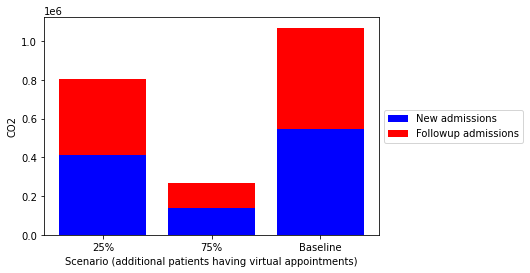

In [18]:
x = range(len(scenarios))

fig, ax = plt.subplots()

ax.bar(x, co2_by_scenario["co2_new"], color='b')
ax.bar(x, co2_by_scenario["co2_followup"], 
       color='r', bottom=co2_by_scenario["co2_new"])

# Put a legend to the right of the current axis
ax.legend(["New admissions", "Followup admissions"],
          loc='center left', bbox_to_anchor=(1, 0.5))

# Add titles
ax.set_xlabel("Scenario (additional patients having virtual "
              "appointments)")
ax.set_ylabel("CO2")
ax.set_xticks(x)
ax.set_xticklabels(co2_by_scenario["scenario_title"])#, rotation=90)

plt.show()

## Output 6: CO2 emissions by scenario, divided by new and followup admissions, and by treatment function
#### Format: Stacked barchart
https://pythonhealthcare.org/2018/04/10/38-matplotlib-bar-charts/

Calculate the values for the bars (top and bottom)

In [19]:
bar_values = co2_by_scen_tf.pivot(index='scenario_title', 
                                  columns='treatment_function')
bar_values

co2_new                                  \
treatment_function 100_general_surgery  101_urology 103_breast_surgery   
scenario_title                                                           
Baseline                   8435.969661  1313.804259       19236.967461   
25%                        6326.977246   985.353194       14427.725596   
75%                        2108.992415   328.451065        4809.241865   

                                                                              \
treatment_function 104_colorectal_surgery 106_upper_gastrointestinal_surgery   
scenario_title                                                                 
Baseline                      6411.743155                        7963.390827   
25%                           4808.807366                        5972.543120   
75%                           1602.935789                        1990.847707   

                                                                         \
treatment_function 107_vascular_surgery       120_ent 130_ophthalmology   
scenario_title                                                            
Baseline                   13991.361886  16586.446367       6807.462941   
25%                        10493.521415  12439.834775       5105.597206   
75%                         3497.840472   4146.611592       1701.865735   

                                                            ...  \
treatment_function 143_orthodontics 171_paediatric_surgery  ...   
scenario_title                                              ...   
Baseline                1879.008427            1817.170552  ...   
25%                     1409.256320            1362.877914  ...   
75%                      469.752107             454.292638  ...   

                        co2_followup                           \
treatment_function 650_physiotherapy 651_occupational_therapy   
scenario_title                                                  
Baseline                20647.081883              9341.027906   
25%                     15485.311412              7005.770929   
75%                      5161.770471              2335.256976   

                                                                  \
treatment_function 652_speech_and_language_therapy 654_dietetics   
scenario_title                                                     
Baseline                               4039.488322  12851.644876   
25%                                    3029.616241   9638.733657   
75%                                    1009.872080   3212.911219   

                                                           \
treatment_function 655_orthoptics 656_clinical_psychology   
scenario_title                                              
Baseline              3348.138904             5189.471229   
25%                   2511.104178             3892.103422   
75%                    837.034726             1297.367807   

                                                                 \
treatment_function 800_clinical_oncology 812_diagnostic_imaging   
scenario_title                                                    
Baseline                     9745.852143            9510.505353   
25%                          7309.389107            7132.879015   
75%                          2436.463036            2377.626338   

                                                         
treatment_function 822_chemical_pathology 840_audiology  
scenario_title                                           
Baseline                      1617.993149  21541.513494  
25%                           1213.494862  16156.135121  
75%                            404.498287   5385.378374  

[3 rows x 130 columns]

Can accesss the different admissions by specifying "co2_new", or "co2_followup" as follows:

In [20]:
 bar_values['co2_new']

treatment_function,100_general_surgery,101_urology,103_breast_surgery,104_colorectal_surgery,106_upper_gastrointestinal_surgery,107_vascular_surgery,120_ent,130_ophthalmology,143_orthodontics,171_paediatric_surgery,...,650_physiotherapy,651_occupational_therapy,652_speech_and_language_therapy,654_dietetics,655_orthoptics,656_clinical_psychology,800_clinical_oncology,812_diagnostic_imaging,822_chemical_pathology,840_audiology
scenario_title,,,,,,,,,,,,,,,,,,,,,
Baseline,8435.969661,1313.804259,19236.967461,6411.743155,7963.390827,13991.361886,16586.446367,6807.462941,1879.008427,1817.170552,...,5940.165105,20396.281285,4376.022883,10202.074102,16715.299014,5159.357454,6070.209065,14717.581051,5388.451321,18434.246359
25%,6326.977246,985.353194,14427.725596,4808.807366,5972.543120,10493.521415,12439.834775,5105.597206,1409.256320,1362.877914,...,4455.123829,15297.210964,3282.017162,7651.555576,12536.474260,3869.518091,4552.656799,11038.185788,4041.338491,13825.684769
75%,2108.992415,328.451065,4809.241865,1602.935789,1990.847707,3497.840472,4146.611592,1701.865735,469.752107,454.292638,...,1485.041276,5099.070321,1094.005721,2550.518525,4178.824753,1289.839364,1517.552266,3679.395263,1347.112830,4608.561590


In [21]:
 bar_values['co2_followup']

treatment_function,100_general_surgery,101_urology,103_breast_surgery,104_colorectal_surgery,106_upper_gastrointestinal_surgery,107_vascular_surgery,120_ent,130_ophthalmology,143_orthodontics,171_paediatric_surgery,...,650_physiotherapy,651_occupational_therapy,652_speech_and_language_therapy,654_dietetics,655_orthoptics,656_clinical_psychology,800_clinical_oncology,812_diagnostic_imaging,822_chemical_pathology,840_audiology
scenario_title,,,,,,,,,,,,,,,,,,,,,
Baseline,10195.474754,745.264069,12207.123246,5172.258697,3385.363377,9564.836597,16375.322135,7905.092313,4357.935849,9107.332628,...,20647.081883,9341.027906,4039.488322,12851.644876,3348.138904,5189.471229,9745.852143,9510.505353,1617.993149,21541.513494
25%,7646.606065,558.948052,9155.342434,3879.194022,2539.022533,7173.627448,12281.491601,5928.819235,3268.451886,6830.499471,...,15485.311412,7005.770929,3029.616241,9638.733657,2511.104178,3892.103422,7309.389107,7132.879015,1213.494862,16156.135121
75%,2548.868688,186.316017,3051.780811,1293.064674,846.340844,2391.209149,4093.830534,1976.273078,1089.483962,2276.833157,...,5161.770471,2335.256976,1009.872080,3212.911219,837.034726,1297.367807,2436.463036,2377.626338,404.498287,5385.378374


Create a stacked barchart for the new admissions

Text(0.5, 1.0, 'CO2 emissions due to new admissions travelling to clinic')

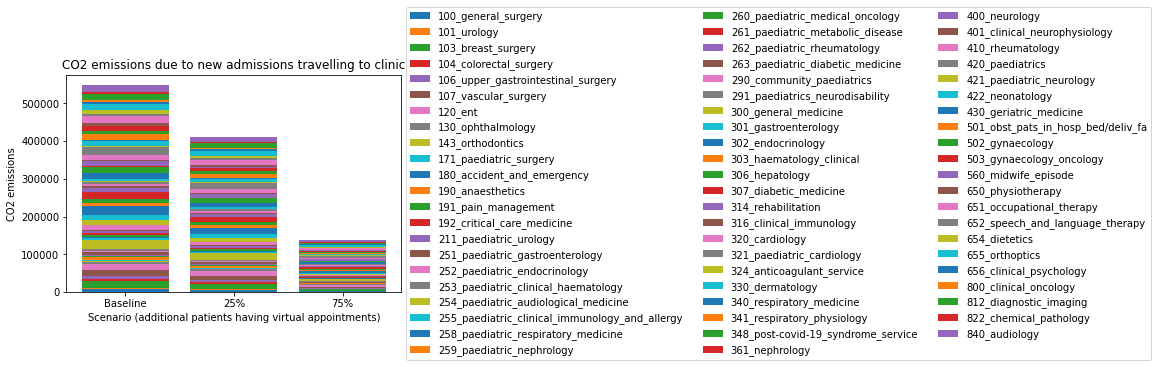

In [22]:
# Remove top level values index
bar_values_new = bar_values['co2_new']
bar_top_new = bar_values_new.cumsum(axis=1)
bar_bottom_new = bar_top_new - bar_values_new

fig, ax = plt.subplots()

labels = list(bar_values.index)

for specialty in list(bar_values_new):
    ax.bar(labels, 
           bar_values_new[specialty], 
           bottom=bar_bottom_new[specialty], 
           label=specialty)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)

# Adding titles
ax.set_xlabel("Scenario (additional patients having virtual "
              "appointments)")
ax.set_ylabel("CO2 emissions")
ax.set_title("CO2 emissions due to new admissions travelling to clinic")

Create a stacked barchart for the followup admissions

Text(0.5, 1.0, 'CO2 emissions due to followup admissions travelling to clinic')

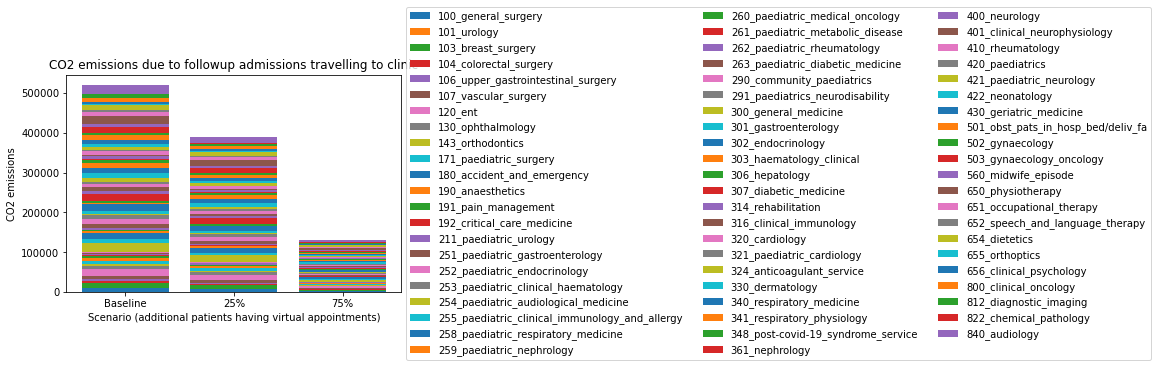

In [23]:
# Remove top level values index
bar_values_followup = bar_values['co2_followup']
bar_top_followup = bar_values_followup.cumsum(axis=1)
bar_bottom_followup = bar_top_followup - bar_values_followup

fig, ax = plt.subplots()

labels = list(bar_values.index)

for specialty in list(bar_values_followup):
    ax.bar(labels, 
           bar_values_followup[specialty], 
           bottom=bar_bottom_followup[specialty],
           label=specialty)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)

# Adding titles
ax.set_xlabel("Scenario (additional patients having virtual "
              "appointments)")
ax.set_ylabel("CO2 emissions")
ax.set_title("CO2 emissions due to followup admissions travelling to clinic")

## DATA PREPARATION TO MAKE MAPS

We need to do some data preparation first before we can make some maps. The following code will explain where I got, and how to use, the required data.

As we have postcode sector data that we want to plot, we need to find a shapefile to provde us with the boundaries.
Googled "postcode sector shapefile" and downloaded a shapefile from https://datashare.ed.ac.uk/handle/10283/2597).
I've already clipped this to create a shapefile for just the Cornwall polygons (see create_cornwall_postcode_sector_file.ipynb).
Let's read in this shapefile as a geopanda dataframe, and take a look at the first 5 rows

In [24]:
pc_sector_shp = gpd.read_file("shapefiles/GB_Postcodes/PostalSector_cornwall.shp")
pc_sector_shp.head()

,RMSect,postcode_s,geometry
0,EX22 6,EX22 6,"POLYGON ((225644.810 101345.299, 225668.440 10..."
1,EX22 7,EX22 7,"POLYGON ((225769.945 103753.740, 225554.773 10..."
2,EX23 0,EX23 0,"POLYGON ((212647.510 94907.892, 212649.002 949..."
3,EX23 8,EX23 8,"MULTIPOLYGON (((220156.905 107457.860, 220205...."
4,EX23 9,EX23 9,"MULTIPOLYGON (((221173.447 117412.880, 221181...."


This shapefile is for the whole of the uk. We can check this by quickly plotting it

<AxesSubplot:>

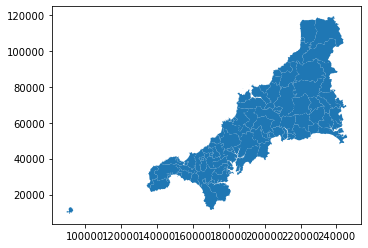

In [25]:
pc_sector_shp.plot()

We can specify the limit of the map, so that we just see the relevant area for Cornwall and Isles of Scilly, and we can set up some of the other arguments to specify the appearance of the map.

In [26]:
xlim_set = (70000, 260000)
ylim_set = (0, 130000)

[(70000.0, 260000.0), (0.0, 130000.0)]

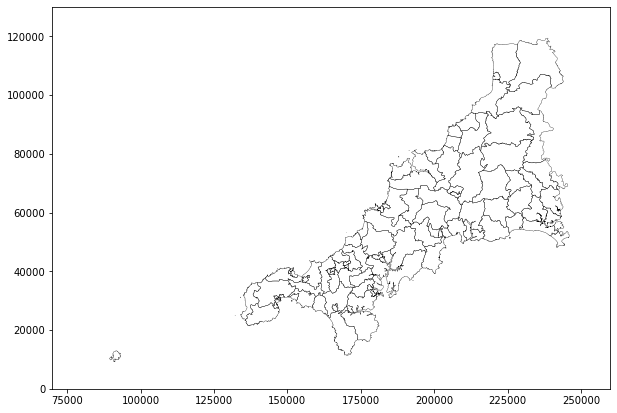

In [27]:
ax = pc_sector_shp.plot(figsize=(10, 10),  zorder=2,
                        linewidth=0.3, edgecolor='k', facecolor='none')

# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

It would be helpful to show the area that is Cornwall on this map. We will do this by finding a Counties shapefile. That way we can plot the county boundaires on the map.

Goggling "county uk shapefile" and I downloaded the files from:
https://data.gov.uk/dataset/11302ddc-65bc-4a8f-96a9-af5c456e442c/counties-and-unitary-authorities-december-2016-full-clipped-boundaries-in-england-and-wales

I've already clipped tihs file to be a shapefile just containing Devon (small enough to share)

Read in the shapefile, look at the first 5 rows and plot it

In [28]:
filename = ("shapefiles/county_boundaries/devon_county.shp")

county_devon_shp = gpd.read_file(filename, 
                             crs='EPSG:4326')
county_devon_shp = county_devon_shp.to_crs(epsg=27700)

county_devon_shp.head()

,objectid,ctyua16cd,ctyua16nm,ctyua16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,130,E10000008,Devon,None,283141,93082,-3.65701,50.725559,6.567162e+09,1.066743e+06,"MULTIPOLYGON (((275519.320 151188.994, 275521...."


<AxesSubplot:>

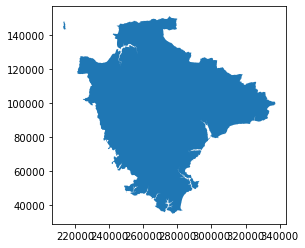

In [29]:
county_devon_shp.plot()

Add this Devon County polygon to our map, make it grey.

[(70000.0, 260000.0), (0.0, 130000.0)]

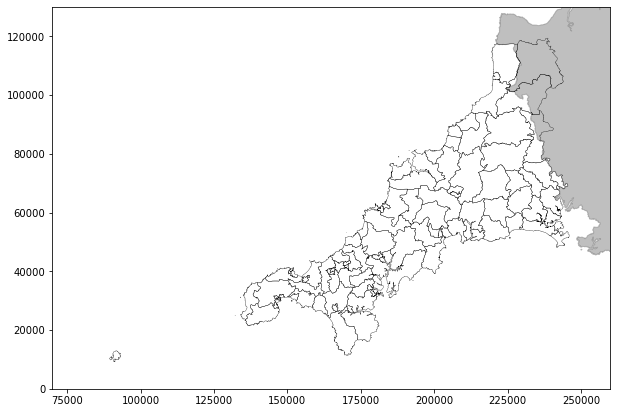

In [30]:
ax = pc_sector_shp.plot(figsize=(10, 10),  zorder=2,
                        linewidth=0.3, edgecolor='k', facecolor='none')

county_devon_shp.plot(ax=ax, zorder=1, edgecolor='grey', 
                      facecolor='grey', alpha=0.5)

# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

We've already loaded the clinic location data into a GeoPandas DataFrame (so we can add points on map for clinic locations). We could use the code below to offset the clinic labels from the point.

for x, y, label in zip(clinic_location.geometry.x, clinic_location.geometry.y, clinic_location.clinic_label):\
        t = ax.annotate(label, xy=(x, y), xytext=(8, 8), textcoords="offset points", backgroundcolor="w", fontsize=8)\
        t.set_bbox(dict(alpha=0.7, facecolor="w", edgecolor='none'))

But as we know all of the clinic locations in advance, and as most are near the coast, it can make the map look clearer if we specify their locations to be on the area of the sea, rather than covering some of the polygons.

To specifiy the label locations, load the clinic label location data file in to a GeoPandas DataFrame. 

In [31]:
clinic_label_location = gpd.read_file(f'{folder}/dummy_clinic_label_locations.csv')
# Set geometry (note easting comes first as GeoPandas expects x/y geometry)
clinic_label_location.geometry = gpd.points_from_xy(
        clinic_label_location.easting, clinic_label_location.northing)
# Set crs for geometry, using epsg27700 for easting/northing
clinic_label_location = clinic_label_location.set_crs(epsg=27700)
clinic_label_location.head()

,clinic_label,easting,northing,geometry
0,West Cornwall,110000,26500,POINT (110000.000 26500.000)
1,Treliske,180000,45000,POINT (180000.000 45000.000)
2,St Michael’s,138000,40500,POINT (138000.000 40500.000)


So now we have the right shapefiles set up to create a basemap that we can add our data to.

We are using four files:
1. a postcode sector shapefile to provide the polygon boundaries. From: https://datashare.ed.ac.uk/handle/10283/2597
1. a county shapefile to provide the Cornwall/Devon divide (the catchment for this project). From: https://data.gov.uk/dataset/11302ddc-65bc-4a8f-96a9-af5c456e442c/counties-and-unitary-authorities-december-2016-full-clipped-boundaries-in-england-and-wales
1. the point locations of the three clinics. This file was created manually.
1. the label locations of the three clinics. This file was created manually.

Action: It would be good in the future to add a base map using contextily

To plot multiple layers on the same map, use the zorder argument to define the order, with 1 at the bottom.

[(70000.0, 260000.0), (0.0, 130000.0)]

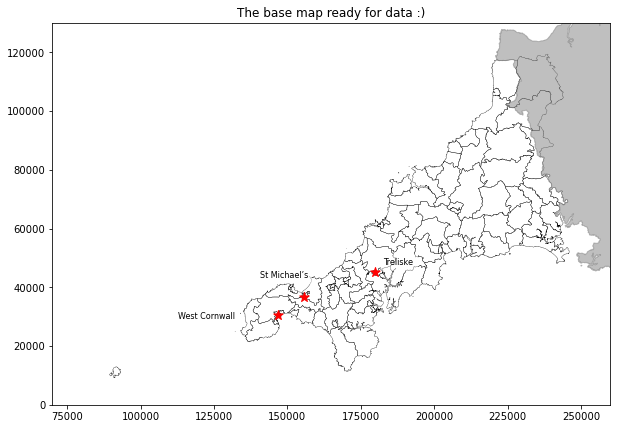

In [32]:
ax = pc_sector_shp.plot(figsize=(10, 10), linewidth=0.3, 
                                 edgecolor='k', facecolor='none')

county_devon_shp.plot(ax=ax, zorder=1, edgecolor='grey', 
                      facecolor='grey', alpha=0.5)

#plot clinic locations
clinic_location.plot(ax=ax, edgecolor='r', facecolor='r', markersize=100, 
                     marker='*', zorder=3)

# add clinic labels (their location is specified by data in file)
#https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
for x, y, label in zip(clinic_label_location.geometry.x, clinic_label_location.geometry.y, 
                       clinic_label_location.clinic_label):
        t = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points",
                       backgroundcolor="w", fontsize=8)
        t.set_bbox(dict(alpha=0.5, facecolor="w", edgecolor='none'))
        
# set title
ax.set_title('The base map ready for data :)')

# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

## Output 7: CO2 emissions due to journey to clinic by new admissions originating from each postcode sector (for baseline scenario)
#### Format: Maps

Now we are ready to add data to our postcode sector shapefile.

Let's plot the CO2 due to a journey originating from each postcode sector (summing over all of the treatment functions).
We need to calculate these vlaues from the master_df. Using groupby

In [33]:
co2_scen_map = (master_df.groupby(["pc_sector", "scenario_title"]).sum()
                [["co2_new","co2_followup","co2_total"]])
co2_scen_map.reset_index(inplace=True)
co2_scen_map

,pc_sector,scenario_title,co2_new,co2_followup,co2_total
0,EX22 6,25%,4673.422214,5214.323175,9887.745389
1,EX22 6,75%,1557.807405,1738.107725,3295.915130
2,EX22 6,Baseline,6231.229618,6952.430900,13183.660518
3,EX22 7,25%,1888.338685,805.018191,2693.356876
4,EX22 7,75%,629.446228,268.339397,897.785625
...,...,...,...,...,...
316,TR8 5,75%,1076.220936,1185.858234,2262.079169
317,TR8 5,Baseline,4304.883743,4743.432935,9048.316678
318,TR9 6,25%,4415.224135,4352.690524,8767.914659
319,TR9 6,75%,1471.741378,1450.896841,2922.638220


For now, let's just plot the values for the Baseline scenario. But we can automate this in a function and create maps for all of the scenarios.

In [34]:
co2_scen_map_baseline = co2_scen_map[co2_scen_map["scenario_title"]=="Baseline"]

Merge this CO2 data into the geopandas postcode sector. That way our data will be available to choose and plot on the map.

In [35]:
gdf_pcs_co2 = \
    pc_sector_shp[['RMSect', 'geometry']].merge(co2_scen_map_baseline, 
                                                left_on=['RMSect'], 
                                                right_on = ['pc_sector'], 
                                                how='inner')
gdf_pcs_co2

,RMSect,geometry,pc_sector,scenario_title,co2_new,co2_followup,co2_total
0,EX22 6,"POLYGON ((225644.810 101345.299, 225668.440 10...",EX22 6,Baseline,6231.229618,6952.430900,13183.660518
1,EX22 7,"POLYGON ((225769.945 103753.740, 225554.773 10...",EX22 7,Baseline,2517.784914,1073.357588,3591.142502
2,EX23 0,"POLYGON ((212647.510 94907.892, 212649.002 949...",EX23 0,Baseline,11959.821833,10287.210641,22247.032474
3,EX23 8,"MULTIPOLYGON (((220156.905 107457.860, 220205....",EX23 8,Baseline,13377.456964,12684.573354,26062.030318
4,EX23 9,"MULTIPOLYGON (((221173.447 117412.880, 221181....",EX23 9,Baseline,10575.794878,9658.470097,20234.264976
...,...,...,...,...,...,...,...
94,TR26 2,"POLYGON ((150687.846 40321.647, 150697.592 402...",TR26 2,Baseline,2176.919555,1765.394533,3942.314088
95,TR26 3,"MULTIPOLYGON (((150858.692 41089.747, 150927.9...",TR26 3,Baseline,2431.078546,1744.325085,4175.403630
96,TR27 4,"POLYGON ((156691.974 37976.819, 156704.918 379...",TR27 4,Baseline,1123.083864,1442.779875,2565.863740
97,TR27 5,"MULTIPOLYGON (((161732.856 42910.156, 161719.9...",TR27 5,Baseline,1728.550533,1750.420880,3478.971413


Plot the CO2 from journeys by new admissions originating in each postcode sector

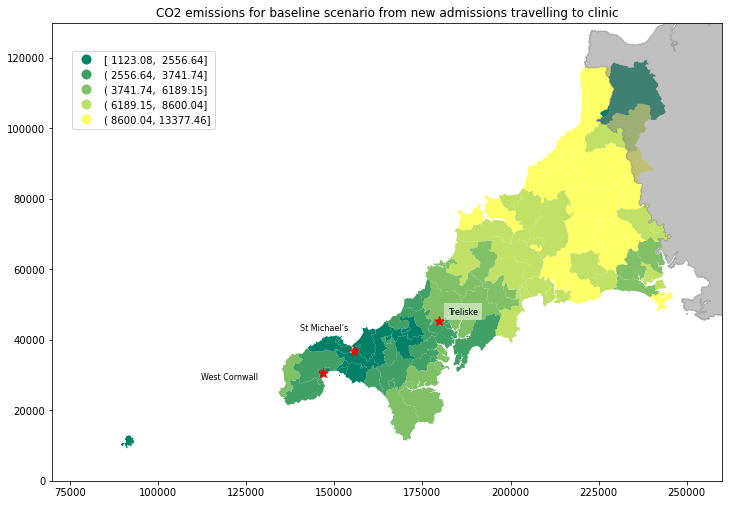

In [36]:
ax = gdf_pcs_co2.plot(column='co2_new', figsize=(12,9), cmap='summer',
                           scheme='quantiles', legend=True,  zorder=1)

# show county boundary
county_devon_shp.plot(ax=ax, zorder=1, edgecolor='grey', 
                      facecolor='grey', alpha=0.5)

#plot clinic locations
clinic_location.plot(ax=ax, edgecolor='r', facecolor='r', markersize=100, 
                     marker='*', zorder=3)

# add clinic labels (their location is specified by data in file)
#https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
for x, y, label in zip(clinic_label_location.geometry.x, clinic_label_location.geometry.y, 
                       clinic_label_location.clinic_label):
        t = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points",
                       backgroundcolor="w", fontsize=8)
        t.set_bbox(dict(alpha=0.5, facecolor="w", edgecolor='none'))
        
# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

# set title
ax.set_title('CO2 emissions for baseline scenario from new admissions '
             'travelling to clinic')

# Relocate legend in the upper left corner
# https://stackoverflow.com/questions/39816790/relocating-legend-from-geopandas-plot
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.05, 0.75, 0.2, 0.2))

## Output 8: CO2 emissions due to journey to clinic by followup admissions originating from each postcode sector (for baseline scenario)
#### Format: Maps

Plot the CO2 from journeys by followup admissions originating in each postcode sector

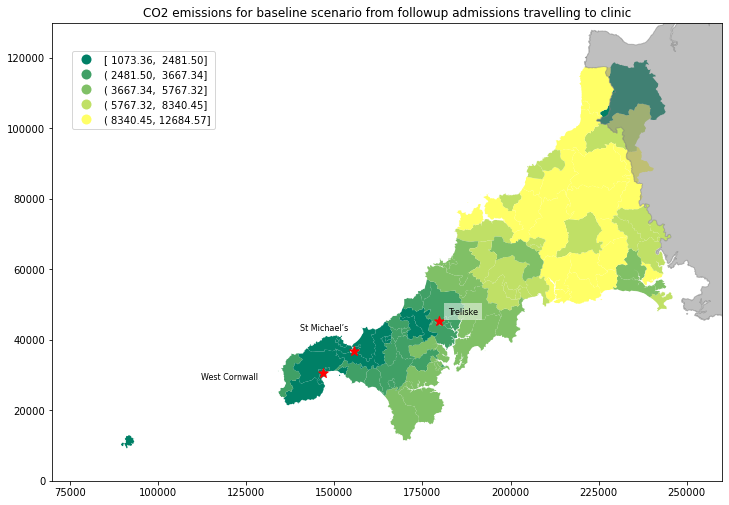

In [37]:
ax = gdf_pcs_co2.plot(column='co2_followup',scheme='quantiles', 
                           figsize=(12,9), cmap='summer',
                           legend=True)

# show county boundary
county_devon_shp.plot(ax=ax, zorder=1, edgecolor='grey', 
                      facecolor='grey', alpha=0.5)

#plot clinic locations
clinic_location.plot(ax=ax, edgecolor='r', facecolor='r', markersize=100, 
                     marker='*', zorder=3)

# add clinic labels (their location is specified by data in file)
#https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
for x, y, label in zip(clinic_label_location.geometry.x, clinic_label_location.geometry.y, 
                       clinic_label_location.clinic_label):
        t = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points",
                       backgroundcolor="w", fontsize=8)
        t.set_bbox(dict(alpha=0.5, facecolor="w", edgecolor='none'))

# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

# set title
ax.set_title('CO2 emissions for baseline scenario from followup admissions '
             'travelling to clinic')

# Relocate legend in the upper left corner
# https://stackoverflow.com/questions/39816790/relocating-legend-from-geopandas-plot
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.05, 0.75, 0.2, 0.2))

## Output 9: CO2 emissions due to journey to clinic by all admissions originating from each postcode sector (for baseline scenario)
#### Format: Maps

Plot the CO2 from journeys by all admissions originating in each postcode sector

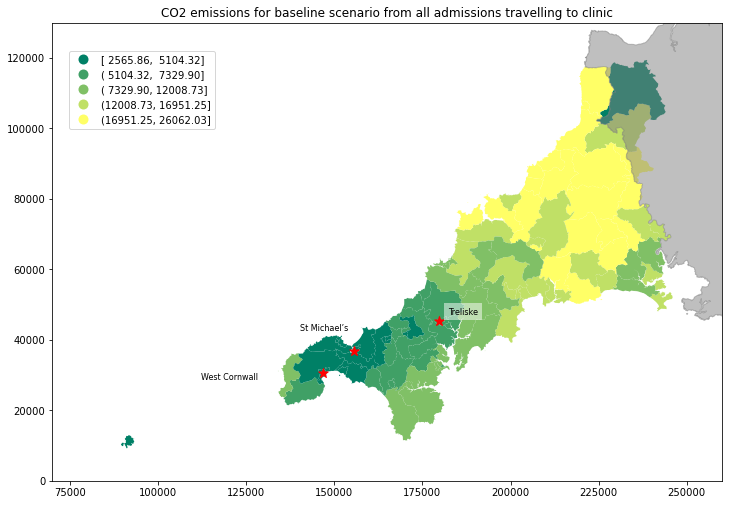

In [38]:
# plot the data in the postcode sector shapefile
ax = gdf_pcs_co2.plot(column='co2_total',scheme='quantiles', 
                           figsize=(12,9), cmap='summer',
                           legend=True)

# show county boundary
county_devon_shp.plot(ax=ax, zorder=1, edgecolor='grey', 
                      facecolor='grey', alpha=0.5)

#plot clinic locations
clinic_location.plot(ax=ax, edgecolor='r', facecolor='r', markersize=100, 
                     marker='*', zorder=3)

# add clinic labels (their location is specified by data in file)
#https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
for x, y, label in zip(clinic_label_location.geometry.x, clinic_label_location.geometry.y, 
                       clinic_label_location.clinic_label):
        t = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points",
                       backgroundcolor="w", fontsize=8)
        t.set_bbox(dict(alpha=0.5, facecolor="w", edgecolor='none'))
        
# zoom on Cornwall & Isles of Scilly
ax.set(xlim=xlim_set, ylim=ylim_set)

# set title
ax.set_title('CO2 emissions for baseline scenario from all admissions '
             'travelling to clinic')

# Relocate legend in the upper left corner
# https://stackoverflow.com/questions/39816790/relocating-legend-from-geopandas-plot
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.05, 0.75, 0.2, 0.2))

## Output 10: Number of admissions seen by each clinic, divided by new and followup admissions, virtual and inperson. For each scenario
#### Format: Table

In [39]:
clinic_admissions = (master_df.groupby(["scenario_title", "clinic_label"]).sum()
                     [["new_adms_inperson","followup_adms_inperson",
                       "new_adms_virtual","followup_adms_virtual"]])
clinic_admissions.reset_index(inplace=True)
clinic_admissions

,scenario_title,clinic_label,new_adms_inperson,followup_adms_inperson,new_adms_virtual,followup_adms_virtual
0,25%,St Michael’s,11352.742904,11382.538969,17231.257096,16245.461031
1,25%,Treliske,14502.874308,13257.661717,22401.125692,23322.338283
2,25%,West Cornwall,6390.600053,6419.439370,10277.399947,10128.560630
3,75%,St Michael’s,3784.247635,3794.179656,24799.752365,23833.820344
4,75%,Treliske,4834.291436,4419.220572,32069.708564,32160.779428
5,75%,West Cornwall,2130.200018,2139.813123,14537.799982,14408.186877
6,Baseline,St Michael’s,15136.990539,15176.718625,13447.009461,12451.281375
7,Baseline,Treliske,19337.165745,17676.882289,17566.834255,18903.117711
8,Baseline,West Cornwall,8520.800070,8559.252493,8147.199930,7988.747507


## Output 11: Number of admissions seen by each clinic, divided by new and followup admissions, virtual and inperson. For each scenario
#### Format: Stacked Barchart

Showing a scenario per barchart. With a bar per clinic. And a stack per admission type (new inperson, followup inperson, new virtual, followup virtual)

In [40]:
def create_stacked_bar_clinic_admissions(clinic_admissions_data, 
                                         scenario_title):
    x = range(clinic_admissions_data.shape[0])

    fig, ax = plt.subplots()

    ax.bar(x, clinic_admissions_data["new_adms_inperson"], color='b')
    bottom = clinic_admissions_data["new_adms_inperson"]
    ax.bar(x, clinic_admissions_data["followup_adms_inperson"], color='r',
           bottom=bottom)
    bottom = bottom + clinic_admissions_data["followup_adms_inperson"]
    ax.bar(x, clinic_admissions_data["new_adms_virtual"], color='k',
           bottom=bottom)
    bottom = bottom + clinic_admissions_data["new_adms_virtual"]
    ax.bar(x, clinic_admissions_data["followup_adms_virtual"], color='g', 
           bottom=bottom)
    
    # Put a legend to the right of the current axis
    ax.legend(["New admissions inperson", "Followup admissions inperson", 
               "New admissions virtual", "followup admissions virtual"],
              loc='center left', bbox_to_anchor=(1, 0.5))    
    # Add titles
    ax.set_xlabel("Clinic")
    ax.set_ylabel("Admissions")
    ax.set_xticks(x)
    ax.set_xticklabels(clinic_admissions_data["clinic_label"])#, rotation=90)
    ax.set_title(f"Number of admissions to each clinic "
                 "(for scenario {scenario_title})")
    plt.show()

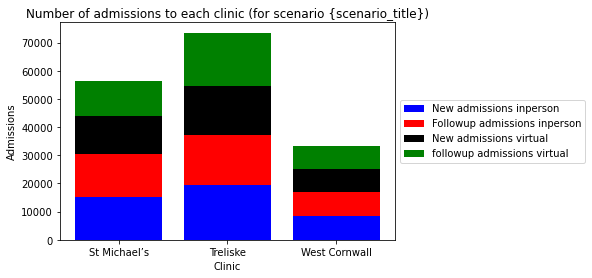

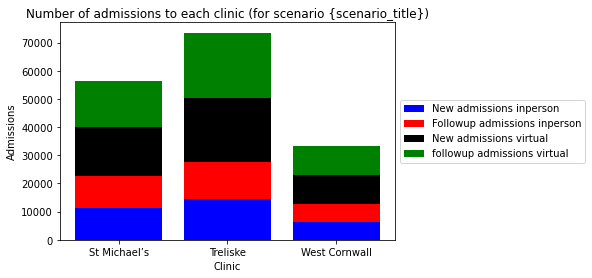

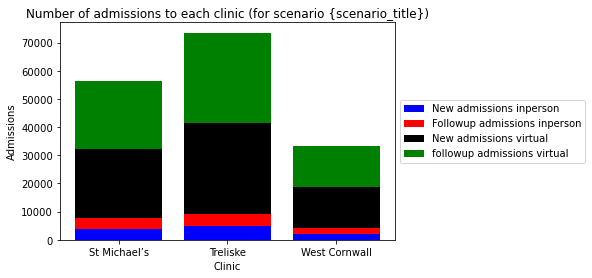

In [41]:
for scen in scenarios:
    clinic_admissions_scen = clinic_admissions[
                            clinic_admissions["scenario_title"]==scen]
    create_stacked_bar_clinic_admissions(clinic_admissions_scen, scen)